[![Neurosnap Header](https://raw.githubusercontent.com/NeurosnapInc/neurosnap/refs/heads/main/assets/header.webp)](https://neurosnap.ai/)

In this tutorial, we will explore how to use the `clusterprot` module from the [Neurosnap SDK package](https://github.com/NeurosnapInc/neurosnap). The focus will be on applying protein clustering algorithms to identify meaningful patterns within protein datasets. Additionally, we will walk through the process of visualizing the clustering results, providing insights into the structural relationships between proteins.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NeurosnapInc/neurosnap/blob/main/example_notebooks/ClusterProt.ipynb)

#### Part 0. Installing Dependencies on Colab

In [1]:
import subprocess
import sys

if 'google.colab' in sys.modules:
    subprocess.run("pip install -U --no-cache-dir git+https://github.com/NeurosnapInc/neurosnap.git", shell=True, check=True, executable="/bin/bash")
    subprocess.run("pip install umap_learn", shell=True, check=True, executable="/bin/bash")

#### Part 1. Clustering Proteins with `ClusterProt`
For the context of the tutorial, we are going to use the results of a demo run of [**Neurosnap AFcluster service**](https://neurosnap.ai/service/AFcluster), which predicts alternative protein conformations.

**AFcluster** is a method that extends the capabilities of AlphaFold2 by enabling the prediction of multiple conformational states of proteins. While AlphaFold2 excels at predicting single structures, many proteins exist in several conformational substates critical to their biological function. AFcluster works by clustering a multiple-sequence alignment based on sequence similarity, which allows AlphaFold2 to sample alternative protein conformations with high confidence. The method has been used to investigate evolutionary distributions and predict structure variations across protein families. For instance, AFcluster successfully predicted alternative states of the metamorphic protein KaiB, which were validated through nuclear magnetic resonance spectroscopy. AFcluster also demonstrated sensitivity to point mutations, accurately predicting conformational flips in mutated proteins, thus revealing potential applications in understanding protein energy landscapes and biological function. (for more information, see the [AFcluster Paper](https://www.nature.com/articles/s41586-023-06832-9))


##### Part 1.1. using the neurosnap `api` module to connect to the neurosnap api and download the results

The neurosnap `api` module allows you to connect to the neurosnap platform using your api key. When you create an instance of the `NeurosnapAPI` class, it automatically checks the validity of your key by making a request to the neurosnap api. If the key is invalid, an error will be raised, prompting you to verify your credentials. This authentication step is crucial for accessing the platform’s features, such as submitting jobs and retrieving data. 

You can generate and manage your api keys by visiting the [neurosnap overview page](https://neurosnap.ai/overview) under the "api Key" section.

For this tutorial, we will use the results of a demo run of **AFcluster** on the following sequence:

**LCLYTHIGRNIYYGSYLYSETWNTGIMLLLITMATAFMGYVLPWGQMSFWGAT**


results page: <https://neurosnap.ai/job/670975de6d01c88797edc749?share=670d746e4ed448ec1bd31467>


In [2]:
import os
import zipfile

from neurosnap.algos.clusterprot import *
from neurosnap.api import *

api_key = os.environ.get('ns_key')
api = NeurosnapAPI(api_key) # replace with your API key

[*] ⚠️ NEVER SHARE YOUR API KEY WITH ANY UNAUTHORIZED PARTIES ⚠️
[*] Successfully connected to the Neurosnap API.
 - For information visit https://neurosnap.ai/blog/post/66b00dacec3f2aa9b4be703a
 - For support visit https://neurosnap.ai/support
 - For bug reports visit https://github.com/NeurosnapInc/neurosnap


In [3]:
api.get_job_data(job_id="670975de6d01c88797edc749", share_id="670d746e4ed448ec1bd31467") # get the job data (config, input files, output files)

{'config': {'Animation Projection Algorithm': 'UMAP',
  'Input Sequence': 'LCLYTHIGRNIYYGSYLYSETWNTGIMLLLITMATAFMGYVLPWGQMSFWGAT',
  'Multiple Sequence Alignment': ''},
 'in': [],
 'out': [['AFcluster Structures.zip', '3.56 MB'],
  ['animation.gif', '17.87 MB'],
  ['results.json', '72.62 KB']]}

In [4]:
# Download the AFcluster structures from the job
file_path = api.get_job_file(
    job_id="670975de6d01c88797edc749",   # Job ID for the AFcluster run
    file_type="out",                     # Specify the type of file (output)
    file_name="AFcluster Structures.zip", # Name of the file to download
    save_path="./AFcluster Structures.zip", # Local path to save the file
    share_id="670d746e4ed448ec1bd31467"   # Share ID
)

[*] File saved to ./AFcluster Structures.zip


In [5]:
# unzip AFcluster Structures.zip
with zipfile.ZipFile('./AFcluster Structures.zip', 'r') as zip_ref:
    zip_ref.extractall('./AFcluster Structures')

##### Part 1.2. ClusterProt Algorithm and Function Explanation

The `ClusterProt` function implements an algorithm for clustering proteins based on their structural similarity. Here's a breakdown of the algorithm and the function:

**Algorithm Overview**

1. **Load and Validate Input**: Ensure all protein structures are fully loaded and valid.
2. **Compute Distance Matrices**: Calculate distance matrices using alpha carbons of all loaded proteins from selected regions.
3. **Flatten Distance Matrices**: Get the flattened upper triangle of the distance matrices, excluding the diagonal.
4. **Align Proteins**: Align all proteins to a reference protein (optional, but useful for analysis like animation).
5. **Create 2D Projection**: Use UMAP (Uniform Manifold Approximation and Projection) to create a 2D projection of the protein structures.
6. **Cluster Proteins**: Apply DBSCAN (Density-Based Spatial Clustering of Applications with Noise) to cluster the 2D projections.
7. **Create 1D Projection**: Generate a 1D projection using either UMAP or PCA (Principal Component Analysis) for organizing proteins one-dimensionally (optional, but useful for visualization).

**Function Parameters**

- `proteins`: List of proteins to cluster (can be Protein objects or file paths)
- `model`: Model ID to use (must be consistent across all structures)
- `chain`: Chain ID to use (must be consistent across all structures, optional)
- `umap_n_neighbors`: The `n_neighbors` value for UMAP (0 for automatic calculation).
- `proj_1d_algo`: Algorithm for 1D projection ("umap" or "pca")
- `dbscan_eps`: The `eps` value for DBSCAN (0 for automatic calculation).
- `dbscan_min_samples`: The `min_samples` value for DBSCAN (0 for automatic calculation).
- `eps_scale_factor`: Scaling factor for DBSCAN's `eps` value.

Now let's run the algorithm on the **AFcluster** structures by creating a list of file paths to the `.pdb` files. These paths will allow us to feed the structures into the **ClusterProt** algorithm for further analysis:


In [ ]:
# List all files in the AFcluster Structures directory
files = os.listdir('./AFcluster Structures')

# create a list of paths to the .pdb files
pdb_paths = [
    f"./AFcluster Structures/{file_name}"
    for file_name in files if file_name.endswith('.pdb')
]

In [7]:
clusters = ClusterProt(pdb_paths, proj_1d_algo="umap") # you can also specify the model and chain

[+] Loading 478 for clustering
[+] Clustering 478 proteins
[+] Computing distance matrices
[+] Aligning all proteins
[+] Creating 2D projection using UMAP (n_neighbors=5)
[+] Creating cluster labels using DBSCAN
[+] Computing 1D projection for animation


#### Part 2. Visualize Results
Now let's visualize the results using two functions: `animate_results` and `create_figure_plotly`.

1. **`animate_results(cp_results, animation_fpath="cluster_prot.gif")`**:
   This function generates an animation that visualizes the aligned proteins and their 1D projections from the **ClusterProt** results. The proteins are sorted by their 1D projections, and for each protein, a pseudo-3D plot is created and added to the animation. The final animation is saved as a GIF file at the specified path.
   
   - **Parameters**:
     - `cp_results`: A dictionary containing the results from the ClusterProt run, including protein structures and their projections.
     - `animation_fpath`: The file path where the animation will be saved.
   

2. **`create_figure_plotly(cp_results)`**:
   This function creates an interactive scatter plot of the 2D projections from the ClusterProt results using the Plotly Express library. Each point represents a protein, with colors indicating the conformation clusters. Hovering over the points reveals additional information about each protein.
   
   - **Parameters**:
     - `cp_results`: A dictionary containing the results from the ClusterProt run, including the 2D projections and cluster labels.
   

Now let's visualize the results:

[+] Drawing animation frames


Creating animation frames for 478/478 proteins


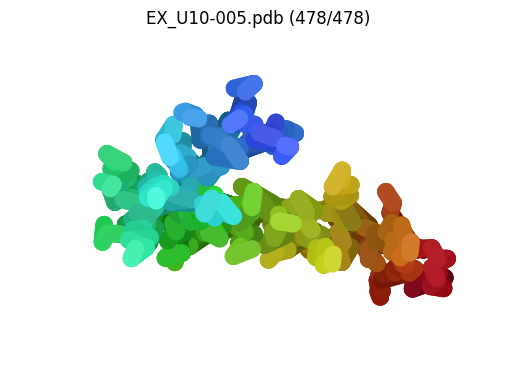

In [8]:
animate_results(clusters, animation_fpath="./cluster_prot.gif") # the animation will be saved in the current directory

![Animation](https://github.com/NeurosnapInc/neurosnap/blob/main/assets/cluster_prot.gif?raw=true "Animation")


In [9]:
create_figure_plotly(clusters)

You can also use the **Neurosnap Platform** for a no-code interface to utilize the following tools:

- **ClusterProt**: <https://neurosnap.ai/service/ClusterProt>
- **AFcluster**: <https://neurosnap.ai/service/AFcluster>

Additionally, you can use the `NeurosnapAPI` class's `.submit_job` method to submit jobs programmatically.

For a more thorough tutorial on the `NeurosnapAPI`, refer to the [Tutorial Notebook](https://github.com/NeurosnapInc/neurosnap/blob/main/example_notebooks/api.ipynb).
